# Tools Setup and Determine Hardware

In [1]:
import os, pathlib
import torch
from torchsummary import summary
from torch import nn
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity
from torchvision import datasets
from torchvision.transforms import ToTensor

from tinyimagenet import TinyImageNet
from TinyImageNetModel import TinyImageNetModel, init_weights
from pathlib import Path
from GPU_Dataset import GPUDS

import numpy as np
import gc

import matplotlib.pyplot as plt

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Dataset Inspection

### Initialize a training and validation set and view data about sample images

TinyImageNet, split "val", has 100000 samples.
Showing info of 2 samples...
Sample of class   0
 Shape torch.Size([3, 64, 64])
 Image Data tensor([[[1.0000, 1.0000, 0.9765,  ..., 0.8157, 0.8196, 0.4980],
         [1.0000, 0.9961, 0.9647,  ..., 0.8039, 0.7922, 0.4824],
         [1.0000, 1.0000, 1.0000,  ..., 0.8118, 0.7922, 0.4706],
         ...,
         [0.3725, 0.3647, 0.3647,  ..., 0.3333, 0.3059, 0.3686],
         [0.3490, 0.3490, 0.3490,  ..., 0.3373, 0.3020, 0.3412],
         [0.3569, 0.3569, 0.3647,  ..., 0.3765, 0.3020, 0.2824]],

        [[0.5333, 0.5412, 0.5725,  ..., 0.9294, 0.9451, 0.6392],
         [0.4941, 0.5020, 0.5373,  ..., 0.9059, 0.9176, 0.6235],
         [0.4941, 0.5059, 0.5294,  ..., 0.9137, 0.9176, 0.6078],
         ...,
         [0.4784, 0.4667, 0.4549,  ..., 0.2902, 0.2627, 0.3255],
         [0.4588, 0.4510, 0.4392,  ..., 0.2941, 0.2588, 0.2980],
         [0.4667, 0.4667, 0.4549,  ..., 0.3333, 0.2588, 0.2392]],

        [[0.7569, 0.7529, 0.7804,  ..., 0.9216, 0

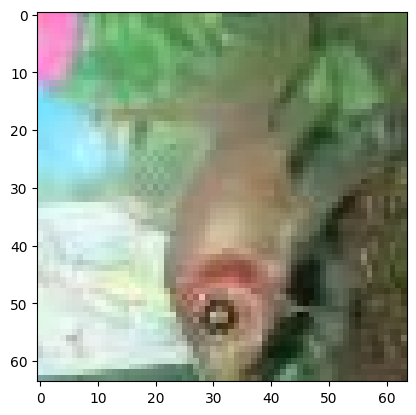

Sample of class 100
 Shape torch.Size([3, 64, 64])
 Image Data tensor([[[0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9725, 0.9647],
         [0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9725, 0.9647],
         [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9765, 0.9725],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 0.0627, 0.0549, 0.0549],
         [0.9922, 0.9922, 0.9922,  ..., 0.0510, 0.0510, 0.0471],
         [0.9922, 0.9922, 0.9922,  ..., 0.0627, 0.0549, 0.0471]],

        [[0.9882, 0.9882, 0.9882,  ..., 0.9922, 1.0000, 1.0000],
         [0.9882, 0.9882, 0.9882,  ..., 0.9922, 1.0000, 1.0000],
         [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9961, 1.0000],
         ...,
         [0.9843, 0.9843, 0.9843,  ..., 0.0706, 0.0706, 0.0784],
         [0.9843, 0.9843, 0.9843,  ..., 0.0667, 0.0745, 0.0824],
         [0.9843, 0.9843, 0.9843,  ..., 0.0863, 0.0784, 0.0824]],

        [[0.9882, 0.9882, 0.9882,  ..., 0.9804, 0.9725, 0.9725],
         [0.9882, 0.9882, 0.9882,  ..., 0.9804, 0.9725, 0.97

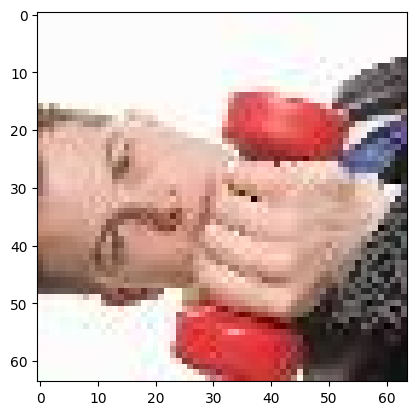

TinyImageNet, split "val", has 10000 samples.
Showing info of 2 samples...
Sample of class   0
 Shape torch.Size([3, 64, 64])
 Image Data tensor([[[0.9686, 0.9725, 0.9804,  ..., 0.9961, 0.9961, 0.9961],
         [0.9843, 0.9804, 0.9804,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9882,  ..., 0.9922, 0.9922, 0.9922],
         ...,
         [0.7765, 0.9333, 1.0000,  ..., 0.8706, 0.8667, 0.8510],
         [0.9608, 0.9686, 0.9020,  ..., 0.9765, 0.9608, 0.9412],
         [0.9490, 0.9333, 0.9608,  ..., 0.9961, 0.9882, 0.9882]],

        [[0.9922, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 0.9961,  ..., 0.9922, 0.9922, 0.9922],
         ...,
         [0.7843, 0.9412, 1.0000,  ..., 0.8706, 0.8667, 0.8510],
         [1.0000, 1.0000, 0.9451,  ..., 0.9765, 0.9725, 0.9529],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000]],

        [[0.9843, 0.9882, 0.9922,  ..., 0.9961, 0.

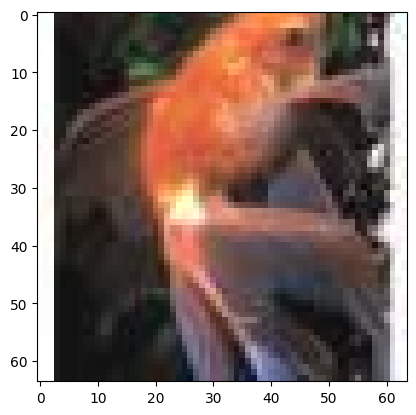

Sample of class 100
 Shape torch.Size([3, 64, 64])
 Image Data tensor([[[0.2549, 0.2157, 0.2941,  ..., 0.2706, 0.3216, 0.2510],
         [0.3373, 0.3255, 0.3373,  ..., 0.2627, 0.2667, 0.2627],
         [0.3569, 0.3961, 0.3961,  ..., 0.3294, 0.1922, 0.2706],
         ...,
         [0.2314, 0.2314, 0.2314,  ..., 0.2510, 0.2549, 0.2588],
         [0.2314, 0.2314, 0.2314,  ..., 0.2588, 0.2627, 0.2627],
         [0.2275, 0.2314, 0.2314,  ..., 0.2510, 0.2510, 0.2510]],

        [[0.3098, 0.2706, 0.3490,  ..., 0.2196, 0.2706, 0.2000],
         [0.3176, 0.3059, 0.3176,  ..., 0.2118, 0.2118, 0.2118],
         [0.1882, 0.2275, 0.2353,  ..., 0.2863, 0.1490, 0.2275],
         ...,
         [0.2353, 0.2353, 0.2353,  ..., 0.2549, 0.2588, 0.2627],
         [0.2353, 0.2353, 0.2353,  ..., 0.2627, 0.2667, 0.2667],
         [0.2314, 0.2353, 0.2353,  ..., 0.2549, 0.2549, 0.2549]],

        [[0.3098, 0.2706, 0.3490,  ..., 0.1961, 0.2471, 0.1765],
         [0.3412, 0.3294, 0.3412,  ..., 0.1882, 0.2000, 0.18

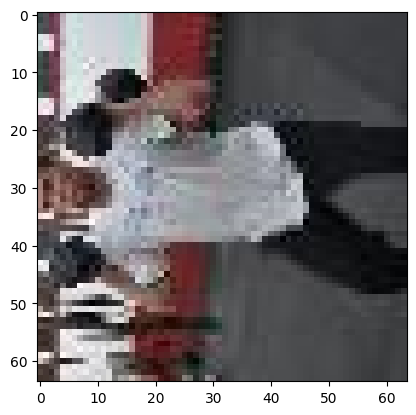

In [2]:
# This cell imports our dataset.

# Original Source: https://github.com/ksachdeva/tiny-imagenet-tfds
# Setup our dataset
# ---------------------------------------------------------

# Training dataset
dataset_path="~/.torchvision/tinyimagenet/"
ds_train = TinyImageNet(Path(dataset_path),split="train")
n = len(ds_train)
print(f"TinyImageNet, split \"val\", has {n} samples.")
samples_to_print = 2
print(f"Showing info of {samples_to_print} samples...")
for i in range(0,n,n//samples_to_print):
    image, img_class = ds_train[i]
    print(f"Sample of class {img_class:3d}\n Shape {image.shape}\n Image Data {image}\n Labels {ds_train.idx_to_words[img_class]}")
    # by default, [C, H, W], transpose to [W, H, C]
    image = np.transpose(image, (2, 1, 0))
    plt.imshow(image)
    plt.show()

# Validation dataset
ds_val = TinyImageNet(Path(dataset_path),split="val")
n = len(ds_val)
print(f"TinyImageNet, split \"val\", has {n} samples.")
samples_to_print = 2
print(f"Showing info of {samples_to_print} samples...")
for i in range(0,n,n//samples_to_print):
    image, img_class = ds_val[i]
    print(f"Sample of class {img_class:3d}\n Shape {image.shape}\n Image Data {image}\n Labels {ds_train.idx_to_words[img_class]}")
    # by default, [C, H, W], transpose to [W, H, C]
    image = np.transpose(image, (2, 1, 0))
    plt.imshow(image)
    plt.show()

### Export three random images to use as input feature maps for C++ framework

In [3]:
# Make a directory for our image data
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

# Dataloaders
val_dataloader = DataLoader(ds_val, batch_size=1, shuffle=True)
train_dataloader = DataLoader(ds_train, batch_size=1, shuffle=True)

i = 0
samples = []
# [num images in batch, channels, width, height] by default
for image, label in val_dataloader:
    if i >= 3:
        break
    else:
        samples.append((image, label))
        # Export sample images
        img_file = open(os.path.join(img_dir, f'image_{i}.bin'), 'wb')
        print(f'Image {i} raw data:\n{image[0]}')
        flattened = torch.flatten(image[0])
        img_file.write(flattened.numpy().astype(np.float32).tobytes())
        img_file.close()
        i = i + 1

Image 0 raw data:
tensor([[[0.2039, 0.2314, 0.1961,  ..., 0.2627, 0.2235, 0.2588],
         [0.3333, 0.2392, 0.3137,  ..., 0.2471, 0.2784, 0.2824],
         [0.3412, 0.3176, 0.1333,  ..., 0.1137, 0.0824, 0.0863],
         ...,
         [0.1176, 0.1373, 0.1451,  ..., 0.0706, 0.0824, 0.1098],
         [0.0549, 0.0706, 0.0941,  ..., 0.0353, 0.0353, 0.0667],
         [0.1294, 0.0941, 0.0941,  ..., 0.0784, 0.0549, 0.0549]],

        [[0.1333, 0.1608, 0.1255,  ..., 0.2118, 0.1647, 0.2000],
         [0.2627, 0.1686, 0.2431,  ..., 0.1961, 0.2196, 0.2235],
         [0.2706, 0.2471, 0.0627,  ..., 0.0627, 0.0235, 0.0275],
         ...,
         [0.0980, 0.1176, 0.1294,  ..., 0.0392, 0.0510, 0.0784],
         [0.0392, 0.0549, 0.0667,  ..., 0.0039, 0.0039, 0.0353],
         [0.1137, 0.0784, 0.0667,  ..., 0.0431, 0.0235, 0.0235]],

        [[0.0941, 0.1216, 0.0863,  ..., 0.1882, 0.1451, 0.1804],
         [0.2235, 0.1294, 0.2039,  ..., 0.1725, 0.2000, 0.2039],
         [0.2314, 0.2078, 0.0235,  ..., 

# Model Loading and Inference



### Load a Pre-Trained Model

In [4]:
# load the network model
model_path = os.path.abspath("./tinyimagenet_model.pt")
model = torch.load(model_path, weights_only=False)

# Checkpoint file has to match the model architecture
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 60, 60]           2,432
              ReLU-2           [-1, 32, 60, 60]               0
            Conv2d-3           [-1, 32, 56, 56]          25,632
              ReLU-4           [-1, 32, 56, 56]               0
         MaxPool2d-5           [-1, 32, 28, 28]               0
            Conv2d-6           [-1, 64, 26, 26]          18,496
              ReLU-7           [-1, 64, 26, 26]               0
            Conv2d-8           [-1, 64, 24, 24]          36,928
              ReLU-9           [-1, 64, 24, 24]               0
        MaxPool2d-10           [-1, 64, 12, 12]               0
           Conv2d-11           [-1, 64, 10, 10]          36,928
             ReLU-12           [-1, 64, 10, 10]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
             ReLU-14            [-1, 12

### Model Inference on Selected 3 Sample Images

In [5]:
# Turn off gradient computation for inference mode
# model.eval()
i = 0
with torch.no_grad():
    for image, label in samples:
        if i >= 3:
            break
        else:
            image = image.to(device)
            # print(image)
            pred = model(image)
            pred = torch.nn.functional.softmax(pred, dim=1)
            top1_guess = torch.max(pred, dim=1)
            # torch.max() returns [value, label_index]
            top1_label = ds_val.idx_to_words[top1_guess[1].item()]
            actual_label = ds_val.idx_to_words[label.item()]
            print(f'Guess: {top1_label} Confidence %: {top1_guess[0].item() * 100} // Actual: {actual_label}')
            i = i + 1

Guess: ['chest'] Confidence %: 14.640356600284576 // Actual: ['boa constrictor', ' Constrictor constrictor']
Guess: ['spiny lobster', ' langouste', ' rock lobster', ' crawfish', ' crayfish', ' sea crawfish'] Confidence %: 31.62289261817932 // Actual: ['spiny lobster', ' langouste', ' rock lobster', ' crawfish', ' crayfish', ' sea crawfish']
Guess: ['cliff', ' drop', ' drop-off'] Confidence %: 51.4387845993042 // Actual: ['suspension bridge']


### Get Accuracy of Top-1, Top-5, and Top-10 classifications of Validation Set

In [6]:
# Set batch size for inference and training purposes
batch_size = 32

total = acc_top1 = acc_top5 = acc_top10 = 0

val_dataloader = DataLoader(ds_val, batch_size=batch_size, shuffle=True)

# batched comp
for images, labels in val_dataloader:
    images_dev = images.to(device)
    labels_dev = labels.to(device)
    model_dev = model.to(device)
    preds = model_dev(images_dev)
    
    #get top-k for this prediction
    #returns a vector of top-k labels for each image in the batch
    top_10 = torch.topk(preds, 10)
    top_5 = torch.topk(preds, 5)
    top_1 = torch.topk(preds, 1)

    # print(top_5[1])

    for image_idx, label in enumerate(labels_dev):
        # is the ground truth label in the top k predictions by the model for that image?
        if label in top_10[1][image_idx]:
            acc_top10 += 1
        if label in top_5[1][image_idx]:
            acc_top5 += 1
        if label in top_1[1][image_idx]:
            acc_top1 += 1
    total += batch_size

print(f'Top1 Accuracy {acc_top1 / total}')
print(f'Top5 Accuracy {acc_top5 / total}')
print(f'Top10 Accuracy {acc_top10 / total}')

Top1 Accuracy 0.22823482428115016
Top5 Accuracy 0.4580670926517572
Top10 Accuracy 0.5756789137380192


### Print All Dataset Classes and their Associated Labels

In [7]:
def get_classes(ds):
    classes = set()

    for img, img_class in ds:
        classes.add(img_class)

    for img_class in classes:
        print(f"Image class: {img_class} // Label: {ds.idx_to_words[img_class]}")

print(f"ds_val classes:\n{get_classes(ds_val)}")
#FIXME this is godawful slow lol
# print(f"ds_train classes:\n{get_classes(ds_train)}")

Image class: 0 // Label: ['goldfish', ' Carassius auratus']
Image class: 1 // Label: ['European fire salamander', ' Salamandra salamandra']
Image class: 2 // Label: ['bullfrog', ' Rana catesbeiana']
Image class: 3 // Label: ['tailed frog', ' bell toad', ' ribbed toad', ' tailed toad', ' Ascaphus trui']
Image class: 4 // Label: ['American alligator', ' Alligator mississipiensis']
Image class: 5 // Label: ['boa constrictor', ' Constrictor constrictor']
Image class: 6 // Label: ['trilobite']
Image class: 7 // Label: ['scorpion']
Image class: 8 // Label: ['black widow', ' Latrodectus mactans']
Image class: 9 // Label: ['tarantula']
Image class: 10 // Label: ['centipede']
Image class: 11 // Label: ['goose']
Image class: 12 // Label: ['koala', ' koala bear', ' kangaroo bear', ' native bear', ' Phascolarctos cinereus']
Image class: 13 // Label: ['jellyfish']
Image class: 14 // Label: ['brain coral']
Image class: 15 // Label: ['snail']
Image class: 16 // Label: ['slug']
Image class: 17 // Labe

# Model Exploration

### Visualize the model layers and filters

First layer weights shape: torch.Size([32, 3, 5, 5])
Last layer weights shape: torch.Size([128, 64, 3, 3])
Number of filters in the first layer: 32
Number of filters in the last layer: 128


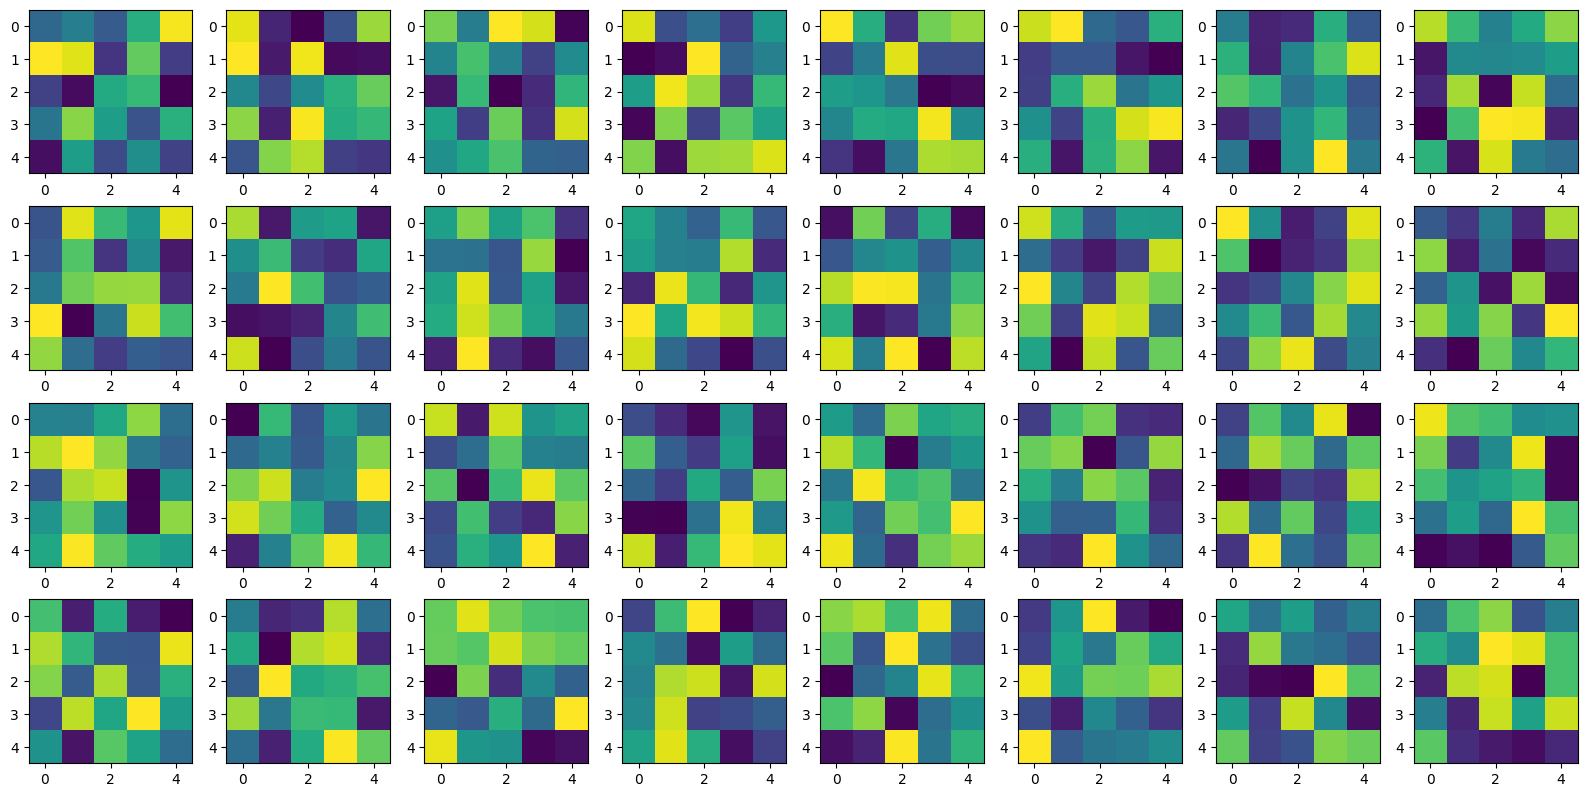

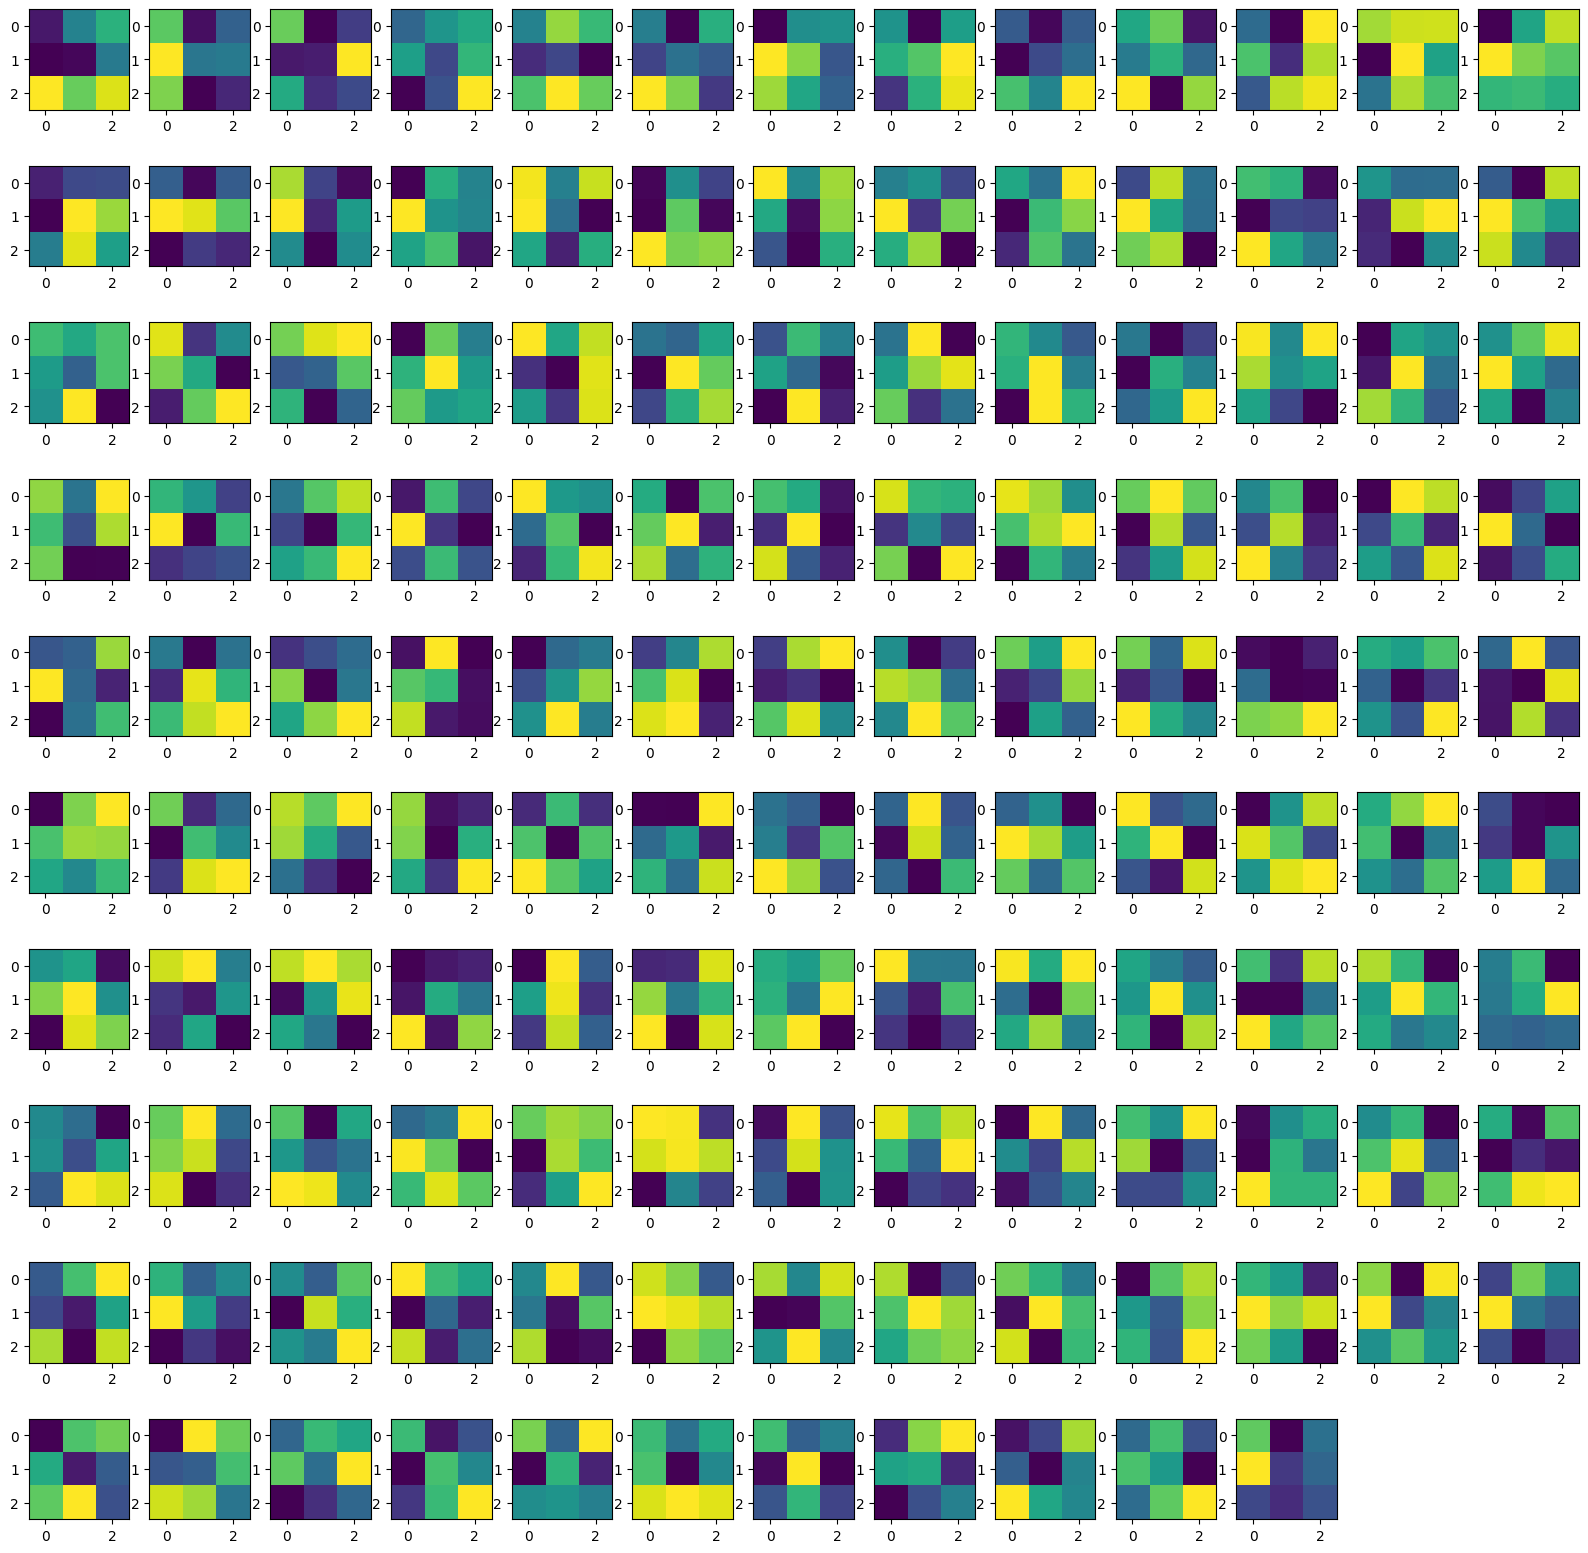

In [8]:
# Visualize the Layer Weigths
# Get the first and last Conv2d layers
conv2d = model.tinyimgnet_model[0]
conv2d_5 = model.tinyimgnet_model[12]

# store the weights of the layers
conv2d_weight = conv2d.weight
conv2d_5_weight = conv2d_5.weight

print(f"First layer weights shape: {conv2d_weight.shape}")
print(f"Last layer weights shape: {conv2d_5_weight.shape}")

num_filters1 = conv2d_weight.shape[0]
num_filters5 = conv2d_5_weight.shape[0]

print(f"Number of filters in the first layer: {num_filters1}") # Expected 5x5
print(f"Number of filters in the last layer: {num_filters5}") # Expected 3x3

# plot the weights of the first layer
plt.figure(figsize=(20, 20))
for i in range(num_filters1):
    plt.subplot(8, 8, i + 1)
    plt.imshow(conv2d_weight[i, 0, :, :].cpu().detach().numpy(), cmap='viridis')
plt.show()

# plot the weights of the last layer
plt.figure(figsize=(20, 20))
for i in range(num_filters5):
    plt.subplot(10, 13, i + 1)
    plt.imshow(conv2d_5_weight[i, 0, :, :].cpu().detach().numpy(), cmap='viridis')
plt.show()

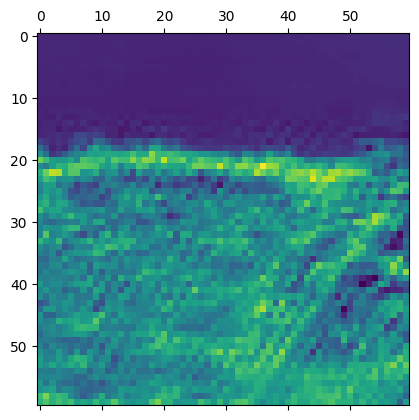

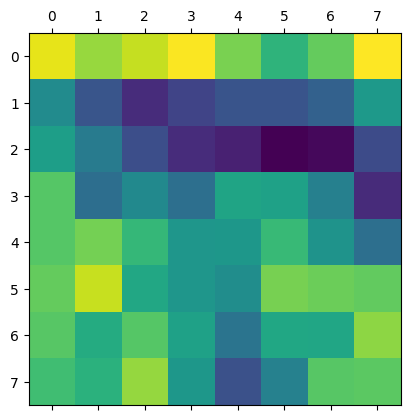

In [9]:
# https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/5
# NOTE: This is definetly something worse than Tensorflow

# Define hooks to get the layer outputs
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks to the layers
conv2d.register_forward_hook(get_activation('conv2d_1'))
conv2d_5.register_forward_hook(get_activation('conv2d_5'))

# Run the model on a few samples from the validation dataset
i = 0
with torch.no_grad():
    for image, label in samples:
        if i >= 3:
            break
        else:
            image = image.to(device)
            pred = model(image)
            i = i + 1

# Access the layer outputs
output_conv2d = activation['conv2d_1']
output_conv2d_5 = activation['conv2d_5']

plt.matshow(output_conv2d[0, 0, :, :].cpu(), cmap='viridis')

plt.matshow(output_conv2d_5[0, 0, :, :].cpu(), cmap='viridis')

### Export Model Params

In [10]:
# Make a directory for our image data
model_dir = os.path.abspath('model_data')
pathlib.Path(model_dir).mkdir(exist_ok=True)

# Export each layer's weights and biases
# These are the convolutional and linear (dense) layers
for layer_num, layer in enumerate(model.tinyimgnet_model):
    if isinstance(layer, nn.Linear):
        layer_type = "Linear"
    elif isinstance(layer, nn.Conv2d):
        layer_type = "Conv2d"
    else:
        continue

    weight_file_name = os.path.join(model_dir, f'{layer_type}_layer{layer_num}_weights.bin')
    bias_file_name = os.path.join(model_dir, f'{layer_type}_layer{layer_num}_biases.bin')

    weight_file = open(weight_file_name, 'wb')
    bias_file = open(bias_file_name, 'wb')

    flat_weights = torch.flatten(layer.weight)
    # .detach() is necessary because we need to extract the weights from the graph or something (idk python errors if you don't use it lol)
    weight_file.write(flat_weights.cpu().detach().numpy().astype(np.float32).tobytes())
    flat_bias = torch.flatten(layer.bias)
    bias_file.write(flat_bias.cpu().detach().numpy().astype(np.float32).tobytes())
    
    weight_file.close()
    bias_file.close()


### Export Intermediate Activations

In [11]:
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

def export_image_activations(img_idx):
    # image subdir
    file_dir = os.path.join(img_dir, f'image_{img_idx}_activations')
    pathlib.Path(file_dir).mkdir(exist_ok=True)
    for layer_num, layer in enumerate(model.tinyimgnet_model):
        if isinstance(layer, nn.ReLU) or isinstance(layer, nn.MaxPool2d):
            # activation num
            activation_file_name = os.path.join(file_dir, f'layer_{layer_num}_activation.bin')
            activation_file = open(activation_file_name, 'wb')

            layer_activation = activation[f"layer_{layer_num}_activation"]
            flat_activation = torch.flatten(layer_activation)

            # write activation to binary as float32's
            activation_file.write(flat_activation.cpu().detach().numpy().astype(np.float32).tobytes())
            activation_file.close()

# NOTE: This is also kinda gross since there's not really a great way to access layer names
# ReLUs, MaxPools, Softmax are the activations we care about

# Hook all the layers
# Uses "activations" array from 2 cells prior
for layer_num, layer in enumerate(model.tinyimgnet_model):
    if isinstance(layer, nn.ReLU) or isinstance(layer, nn.MaxPool2d):
        # model.tinyimgnet_model[layer_num].register_forward_hook(get_activation(f"layer_{layer_num}_activation"))
        layer.register_forward_hook(get_activation(f"layer_{layer_num}_activation"))

# Inference on three sample images
i = 0
with torch.no_grad():
    for image, label in samples:
        if i >= 3:
            break
        else:
            image = image.to(device)
            pred = model(image)
            export_image_activations(i)
            i = i + 1        

# Inference Performance Profiling

### Profile One Image

In [12]:
# Gather grab a profiling trace on one of the sample images

activities = [ProfilerActivity.CPU]
with profile(activities=activities, record_shapes=True) as prof:
    with record_function("end_to_end_inference"):
        model(samples[0][0].to(device)) 

# opening this with perfetto ui is actually pretty neat and way easier than tensorboard
prof.export_chrome_trace("image_0_trace.json")
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                end_to_end_inference        32.16%     426.877us       100.00%       1.327ms       1.327ms             1  
                        aten::conv2d         1.20%      15.940us        30.09%     399.286us      66.548us             6  
                   aten::convolution         3.06%      40.670us        28.88%     383.346us      63.891us             6  
                  aten::_convolution         3.59%      47.581us        25.82%     342.676us      57.113us             6  
             aten::cudnn_convolution        10.58%     140.432us        16.71%     221.715us      36.953us             6  
                

### Online Inference

In [13]:
samples_to_run = [10, 100, 1000]

val_dataloader = DataLoader(ds_val, batch_size=1, shuffle=True)

for samples_num in samples_to_run:
    # Engage profiling
    with profile(activities=activities) as prof:
        with record_function(f"e2e_online_{samples_num}"):
            i = 0
            # run inference
            with torch.no_grad():
                for single_image, image_label in val_dataloader:
                    model(single_image.to(device))
                    
                    if i >= samples_num:
                        break

                    i += 1

    prof.export_chrome_trace(f"online_inf_{samples_num}_trace.json")
    print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          e2e_online_10        94.88%     225.297ms       100.00%     237.456ms     237.456ms             1  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...         1.53%       3.634ms         1.85%       4.387ms     398.820us            11  
                                           aten::conv2d         0.04%      88.853us         1.66%       3.953ms      59.889us            66  
                                      aten::convolution         0.07%     158.613us         1.63%       3.864ms      58.542us            66  
      

### Batch Inference

In [14]:
batch_sizes = [32, 64, 128, 256]
max = 10240

# NOTE: Total exec time gets slower with higher batch sizes. The total number of inferences is the same for all runs

for size in batch_sizes:
    val_dataloader = DataLoader(ds_val, batch_size=size, shuffle=True)

    # Engage profiling
    with profile(activities=activities) as prof:
        with record_function(f"e2e_batch_{size}"):
            with torch.no_grad():
                i = 0
                for images, labels in val_dataloader:
                    model(images.to(device))
                    
                    i = i + size
                    if i == max:
                        break

    prof.export_chrome_trace(f"batch_inf_{size}_trace.json")
    print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           e2e_batch_32         3.28%      86.000ms       100.00%        2.625s        2.625s             1  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...        65.12%        1.710s        88.15%        2.314s       7.370ms           314  
                                               aten::to         0.57%      14.993ms         7.01%     184.121ms       8.927us         20626  
                                            aten::copy_         5.07%     133.139ms         6.75%     177.167ms       5.845us         30313  
      

# Model Training

### Set up the Training Options

In [15]:
activities = [ProfilerActivity.CUDA]

models_dir = os.path.abspath('trained_models')
pathlib.Path(models_dir).mkdir(exist_ok=True)

### Training Loop

In [16]:
import time

# NOTE: This part is also definitely more verbose

def train_network(dataloader, epochs, batch_size, train_type):
    type_dir = os.path.join(models_dir, train_type)
    pathlib.Path(type_dir).mkdir(exist_ok=True)

    # create a new model and initialize it
    model = TinyImageNetModel(lr=.0003, device=device).to(device)
    model.apply(init_weights)

    #return the optimizer (adamax)
    opt = model.configure_optimizers()
    summary(model, input_size=(3, 64, 64))
    print(f"BEGINNING INFERENCE -- BATCH_SIZE={batch_size} FOR {epochs} EPOCHS")
    
    # enable gradient computation
    model.train()
    i = 0
    epoch_loss = 0.
    epoch_accuracy = 0.

    # begin the training loop
    for epoch in range(epochs):
        start_time = time.time() * 1000  # Convert to milliseconds
        print(f'EPOCH: {epoch}')
        
        for data, labels in dataloader:
            loss, accuracy = model.training_step((data, labels))
            epoch_loss += loss
            epoch_accuracy += accuracy
            opt.zero_grad()
            loss.backward()
            opt.step()
            i += 1
            del loss
            del accuracy

        gc.collect()
        end_time = time.time() * 1000
        elapsed_time = (end_time - start_time) / 1000.0
        print(f"Elapsed time for Epoch {epoch}: {elapsed_time:.2f} seconds")
        print(f"Average loss for Epoch {epoch}: {epoch_loss / i}\t Train accuracy: {epoch_accuracy / i}")


    # Save the model at the end of each training run
    torch.save(model, os.path.join(type_dir, f'{train_type}_train_{batch_size}_{epochs}.pt'))
    # print(prof.key_averages().table(row_limit=20))


### Training with Different Batch Sizes

In [17]:
batch_size = [32, 64, 128]

# Move the whole dataset to the GPU before training
gpu_dataset = GPUDS(ds_train, device)

for bs in batch_size:
    # train_dataloader = DataLoader(ds_train, batch_size=bs, shuffle=True)
    gpu_dataloader = torch.utils.data.DataLoader(gpu_dataset, batch_size=bs, shuffle=True)
    epochs = 20
    total_start = time.time() * 1000
    train_network(gpu_dataloader, epochs, bs, 'batch')
    total_end = time.time() * 1000
    train_time = (total_end - total_start) / 1000.0
    print(f"Total training time for batch size {bs}: {train_time:.2f} seconds")

torch.cuda.empty_cache()

/home/alex/Documents/School/487_Proj/pytorch/GPU_Dataset.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = [(torch.tensor(x).to(device), torch.tensor(y).to(device)) for x, y, in dataset]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 60, 60]           2,432
              ReLU-2           [-1, 32, 60, 60]               0
            Conv2d-3           [-1, 32, 56, 56]          25,632
              ReLU-4           [-1, 32, 56, 56]               0
         MaxPool2d-5           [-1, 32, 28, 28]               0
            Conv2d-6           [-1, 64, 26, 26]          18,496
              ReLU-7           [-1, 64, 26, 26]               0
            Conv2d-8           [-1, 64, 24, 24]          36,928
              ReLU-9           [-1, 64, 24, 24]               0
        MaxPool2d-10           [-1, 64, 12, 12]               0
           Conv2d-11           [-1, 64, 10, 10]          36,928
             ReLU-12           [-1, 64, 10, 10]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
             ReLU-14            [-1, 12

### Training with Different Epochs

In [18]:
epochs_list = [3, 10, 100]

for epochs in epochs_list:
    gpu_dataloader = torch.utils.data.DataLoader(gpu_dataset, batch_size=bs, shuffle=True)
    total_start = time.time() * 1000
    train_network(gpu_dataloader, epochs, 32, 'epoch')
    total_end = time.time() * 1000
    train_time = (total_end - total_start) / 1000.0
    print(f"Total training time for epoch size {epochs}: {train_time:.2f} seconds")

torch.cuda.empty_cache()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 60, 60]           2,432
              ReLU-2           [-1, 32, 60, 60]               0
            Conv2d-3           [-1, 32, 56, 56]          25,632
              ReLU-4           [-1, 32, 56, 56]               0
         MaxPool2d-5           [-1, 32, 28, 28]               0
            Conv2d-6           [-1, 64, 26, 26]          18,496
              ReLU-7           [-1, 64, 26, 26]               0
            Conv2d-8           [-1, 64, 24, 24]          36,928
              ReLU-9           [-1, 64, 24, 24]               0
        MaxPool2d-10           [-1, 64, 12, 12]               0
           Conv2d-11           [-1, 64, 10, 10]          36,928
             ReLU-12           [-1, 64, 10, 10]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
             ReLU-14            [-1, 12

# Validate the Newly Trained Models

### Helper Function for Top-K with a Model

In [19]:
def compute_acc_with_model(model):
    acc_top1 = acc_top5 = acc_top10 = total = 0
    val_dataloader = DataLoader(ds_val, batch_size=32, shuffle=True)

    # batched comp
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            preds = model(images)
            
            #get top-k for this prediction
            #returns a vector of top-k labels for each image in the batch
            top_10 = torch.topk(preds, 10)
            top_5 = torch.topk(preds, 5)
            top_1 = torch.topk(preds, 1)

            # print(top_5[1])

            for image_idx, label in enumerate(labels):
                # is the ground truth label in the top k predictions by the model for that image?
                if label in top_10[1][image_idx]:
                    acc_top10 += 1
                if label in top_5[1][image_idx]:
                    acc_top5 += 1
                if label in top_1[1][image_idx]:
                    acc_top1 += 1
            total += 32

        print(f'Top1 Accuracy {acc_top1 / total}')
        print(f'Top5 Accuracy {acc_top5 / total}')
        print(f'Top10 Accuracy {acc_top10 / total}')

### Batch Size Models

In [21]:
for size in [32, 64, 128]:
    batch_model_path = os.path.abspath(f"trained_models/batch/batch_train_{size}_20.pt")
    batch_model = torch.load(batch_model_path, weights_only=False)
    batch_model.eval()
    print(f"Loaded batch{size} model")

    compute_acc_with_model(batch_model)

Loaded batch32 model
Top1 Accuracy 0.2270367412140575
Top5 Accuracy 0.4598642172523962
Top10 Accuracy 0.577276357827476
Loaded batch64 model
Top1 Accuracy 0.2305311501597444
Top5 Accuracy 0.46685303514376997
Top10 Accuracy 0.5860623003194888
Loaded batch128 model
Top1 Accuracy 0.22064696485623003
Top5 Accuracy 0.44878194888178913
Top10 Accuracy 0.5695886581469649


### Epoch Models

In [22]:
for epochs in [3, 10, 100]:
    epoch_model_path = os.path.abspath(f"trained_models/epoch/epoch_train_32_{epochs}.pt")
    epoch_model = torch.load(epoch_model_path, weights_only=False)
    epoch_model.eval()
    print(f"Loaded epoch{size} model")

    compute_acc_with_model(epoch_model)

Loaded epoch128 model
Top1 Accuracy 0.11401757188498403
Top5 Accuracy 0.2878394568690096
Top10 Accuracy 0.3981629392971246
Loaded epoch128 model
Top1 Accuracy 0.2010782747603834
Top5 Accuracy 0.4216253993610224
Top10 Accuracy 0.5393370607028753
Loaded epoch128 model
Top1 Accuracy 0.17661741214057508
Top5 Accuracy 0.3791932907348243
Top10 Accuracy 0.49740415335463256
